<a href="https://colab.research.google.com/github/Inbal-Schekler/UNET-flocks-detection/blob/main/UNET_Soaring_birds_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

### **Imports**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
import keras
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model
from keras import metrics
from keras import regularizers
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
from datetime import datetime
import re
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc

When working with GCP buckets

In [ ]:
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

In [ ]:
!mkdir colab_direcoty

!gcsfuse --implicit-dirs radar_data_israel colab_direcoty

In [ ]:
!ls colab_direcoty

### **Dataset**

Note that In each floder we have tiff images of the radial velocity radar parametr and png images of the annotated images.

In [ ]:
### list of train images

train_files = glob.glob('colab_direcoty/train/*/*.tiff')
print("length of train files",len(list_train_files))

### list of test images

train_files = glob.glob('colab_direcoty/test/*/*.tiff')
print("length of test files",len(train_files))


Function to add two previos images only if the gap of time between each two images is less than 7 minuts

In [ ]:

sz = (256, 256)

def create_early_image_2 (files,file, num_past, minuts):
  time = datetime.strptime(re.search('--(.*)_', os.path.basename(file)).group(1).replace('-', ' '),
                                      '%Y%m%d %H%M%S')
  index= files.index(file)
  time_prev = datetime.strptime(re.search('--(.*)_', os.path.basename(files[index - 1])).group(1).replace('-', ' '),
                '%Y%m%d %H%M%S')
  file_prev=files[index-1]
  delta = (time - time_prev).seconds / 60
  if delta < minuts:
    image_prev= Image.open(file_prev)
    image_prev = image_prev.crop(box)
    image_prev = image_prev.resize(sz)
    image_prev = np.array(image_prev)

    if num_past>1:
      time_prev_2 = datetime.strptime(re.search('--(.*)_', os.path.basename(files[index - 2])).group(1).replace('-', ' '),
                  '%Y%m%d %H%M%S')
      
      file_prev_2=files[index-2]
      delta_2 = (time_prev - time_prev_2).seconds / 60
      if delta_2 < minuts:
        image_prev_2= Image.open(file_prev_2)
        image_prev_2 = image_prev_2.crop(box)
        image_prev_2 = image_prev_2.resize(sz)
        image_prev_2 = np.array(image_prev_2)
       

        image_prev_all = np.concatenate((image_prev, image_prev_2),axis=2 )
       

      else:
        
        image_prev_all=[]

  else:
        
      image_prev_all=[]
      
   
   
  return image_prev_all

##**Generators**


In [ ]:
box = (29, 29, 450, 450)
num_past=2 
minuts=7

def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  
 while True: 
    
    #extract a random batch  
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    
    for f in batch:
        


        #preprocess the raw images 
        raw = Image.open(f)
        raw = raw.crop(box)
        raw = raw.resize(sz)
        raw = np.array(raw)

        prev_image=create_early_image_2 (files,f,num_past, minuts)
        if len(prev_image)==0:
          
          continue
        else: 
          raw_prev=np.concatenate((raw, prev_image),axis=2)

        
        batch_x.append(raw_prev)
        

        #get the masks. Note that masks are png files
        f_path= os.path.dirname(f) 
        num_f= str(int(os.path.basename(f).split('-')[0]))
        mask_file=[i for i in os.listdir(f_path) if os.path.isfile(os.path.join(f_path,i)) and 
         num_f == (os.path.basename(i).split('-')[0]) and '.png' in i]
        if len(mask_file)==0:
          mask=np.zeros((256,256))
        else:
          mask_file=str(mask_file)[2:-2]
          mask_path = os.path.join(f_path, mask_file) 
          mask = Image.open(mask_path).convert ('L')
          mask = mask.crop (box)
          mask = np.array(mask.resize(sz))

        
          
          mask[mask != 0 ] = 1
        
        batch_y.append(mask)


    # preprocess a batch of images and masks 
    batch_x = np.array(batch_x)/255.
    batch_y = np.array(batch_y)
   
    batch_y = np.expand_dims(batch_y,3)

    yield (batch_x, batch_y)      



In [ ]:

batch_size = 32


train_generator = image_generator(train_files, batch_size = batch_size)
test_generator  = image_generator(test_files, batch_size = batch_size)

In [ ]:
x, y= next(test_generator)
print (x.shape)
print(y.shape)

(-0.5, 255.5, 255.5, -0.5)

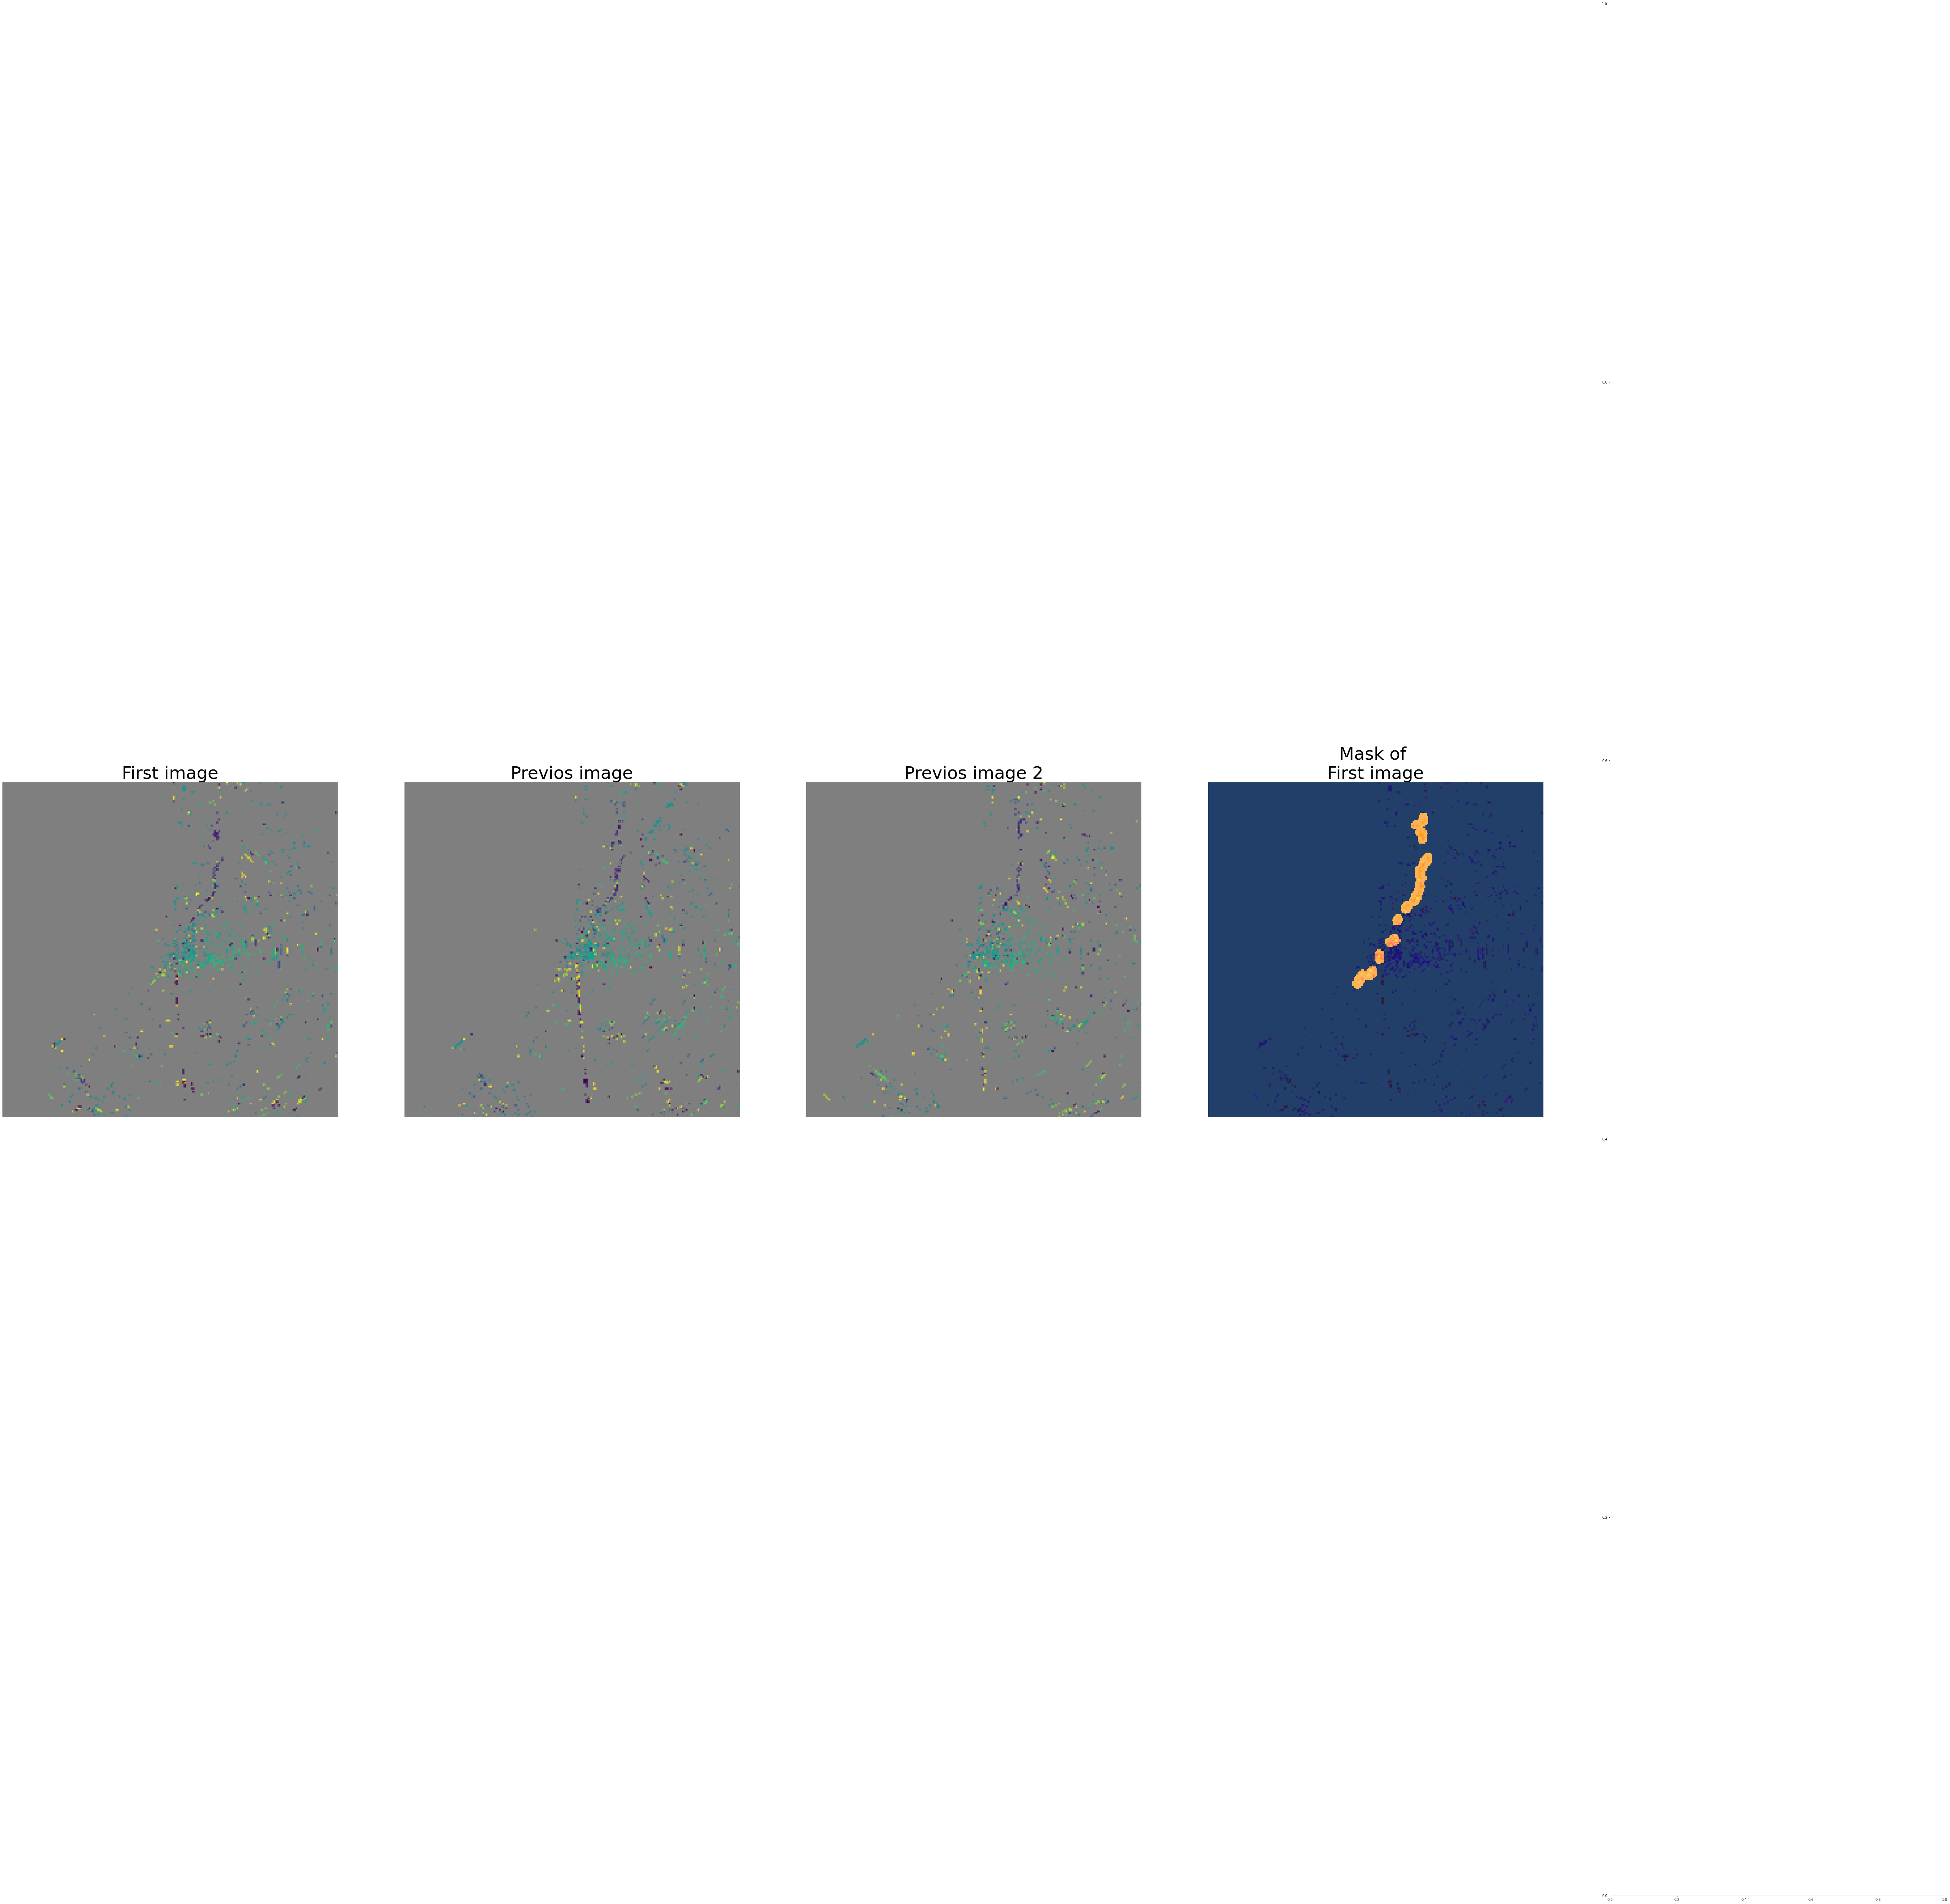

In [ ]:

img_2 = x[0]
img=img_2[:,:,0:3]


img_prev=img_2[:,:,3:6]


img_prev_2 = img_2[:,:,6:9]

msk = y[0]


# Make a True/False mask of pixels whose BGR values sum to more than zero
alpha = np.sum(msk, axis=-1) > 0
unique, counts = np.unique(alpha, return_counts=True)
alpha_2 = np.sum(msk) > 0


# Convert True/False to 0/255 and change type to "uint8" to match "na"
alpha = np.uint8(alpha * 255)


# Stack new alpha layer with existing image to go from BGR to BGRA, i.e. 3 channels to 4 channels
res = np.dstack((alpha, img))


f, axarr = plt.subplots(1,5, figsize=(100,100))
axarr[0].imshow(img)
axarr[0].axis ('off')
axarr[0].set_title('First image', fontsize=50)

axarr[1].imshow(img_prev)
axarr[1].axis ('off')
axarr[1].set_title('Previos image', fontsize=50)

axarr[2].imshow(img_prev_2)
axarr[2].axis ('off')
axarr[2].set_title('Previos image 2', fontsize=50)

axarr[3].imshow(msk.squeeze())
axarr[3].axis ('off')
axarr[3].set_title('Mask of \nFirst image', fontsize=50)

axarr[4].imshow(res)
axarr[4].axis ('off')



# IOU metric

The intersection over union (IoU) metric is a simple metric used to evaluate the performance of a segmentation algorithm. 


In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

### **The model**

In [ ]:

def unet(sz = (256, 256, 9)):
  x = Input(sz)
  inputs = x
  
  #down sampling 
  f = 8
  layers = []
  


  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64  
  
  #bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  #upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  #classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
 
  #model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou, 'accuracy'])
  
  return model

In [ ]:

model = unet()

### **Callbacks**



Functions to save the model at each epoch and show some predictions 

In [ ]:
def build_callbacks():
        filepath = 'my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'
        checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        
        return callbacks

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):

    def on_train_begin(self, logs={}): 
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        raw_prev=[]
        while len(raw_prev)==0:
            #choose a random test image and preprocess
            path = np.random.choice(test_files)
            raw = Image.open(f'{path}')
            raw = raw.crop(box)
            raw = np.array(raw.resize((256, 256)))/255.
            raw = raw[:,:,0:3]

            prev_image=create_early_image_2 (test_files,path,num_past, minuts)
            if len(prev_image)!=0:
              raw_prev=np.concatenate((raw, prev_image),axis=2)
            


        ## add the original mask
        f_path= os.path.dirname(path) 
        num_f= str(int(os.path.basename(path).split('-')[0]))
        mask_file=[i for i in os.listdir(f_path) if os.path.isfile(os.path.join(f_path,i)) and 
         num_f == (os.path.basename(i).split('-')[0]) and '.png' in i]
        if len(mask_file)==0:
          mask=np.zeros((256,256))
        else:
          mask_file=str(mask_file)[2:-2]
          mask_path = os.path.join(f_path, mask_file) 
          mask = Image.open(mask_path).convert ('L')
          mask = mask.crop (box)
          mask=np.array(mask.resize ((256,256)))
    
        
          ## changing the mask to be only 0/1
          mask[mask != 0 ] = 1
          
        
        
        #predict the mask 
        pred = model.predict(np.expand_dims(raw_prev, 0))
        pred=pred.squeeze()
        
        pred_0_1=np.copy(pred)
        pred_0_1[pred_0_1>=0.5] = 1
        pred_0_1[pred_0_1<0.5] = 0
        
        



        f, axarr = plt.subplots(1,3)
        axarr[0].imshow(raw)
        axarr[0].axis ('off')
        axarr[0].set_title('Radar image')
        axarr[1].imshow(mask)
        axarr[1].axis ('off')
        axarr[1].set_title('Mask Ground truth')
        axarr[2].imshow(pred)
        axarr[2].axis ('off')
        axarr[2].set_title('Prediction')
        
        
 
        plt.show()
        

    
       

###**Training**

In [ ]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size
history=model.fit_generator(train_generator,               
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps,
                     callbacks = build_callbacks(),verbose = 1)



In [ ]:
model.save('unet_2_prev_images')

with open('trainHistoryDict_unet_2_prev_images', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

The performance figures





In [ ]:
## plot the figurs of accuracy, loss and IOU

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

plt.style.use('default')
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('model iou')
plt.ylabel('iou')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
